# Preprocesamiento y pruebas

## Pruebas equivalencias VAE-GAN y HIFI-GAN

In [ ]:
import librosa
import numpy as np

min_level_db=-100
def amp_to_db(x):
        return 20 * np.log10(np.maximum(1e-5, x))
def vae_normalize(S):
        return np.clip((S - min_level_db) / -min_level_db, 0, 1)

def audio_preprocess_vae_gan(path, sample_rate, audio_norm_target_dBFS=-30):
    def normalize_volume(wav, target_dBFS, increase_only=False, decrease_only=False):
        if increase_only and decrease_only:
            raise ValueError("Both increase only and decrease only are set")
        dBFS_change = target_dBFS - 10 * np.log10(np.mean(wav ** 2))
        if (dBFS_change < 0 and increase_only) or (dBFS_change > 0 and decrease_only):
            return wav
        return wav * (10 ** (dBFS_change / 20))
    
    wav, source_sr = librosa.load(str(path), sr=None)

    # Resample the wav if needed
    if source_sr is not None and source_sr != sample_rate:
        wav = librosa.resample(wav, source_sr, sample_rate)

    # Apply the preprocessing: normalize volume and shorten long silences
    wav = normalize_volume(wav, audio_norm_target_dBFS, increase_only=True)
    return wav

In [ ]:
import librosa
from librosa.util import normalize
from meldataset import get_test_filelist, spectral_normalize_torch
import json
import numpy as np

with open('config_v1.json') as f:
    data = f.read()
json_config = json.loads(data)
h = AttrDict(json_config)
test_filelist = get_test_filelist('data', 'test_refs.txt')

audio_raw = librosa.load(test_filelist[2], sr=22050)[0]
audio_vae_norm = audio_preprocess_vae_gan(test_filelist[2], 22050)
audio_hifi_norm = normalize(audio_raw) * 0.95

print(f'Audio Raw: Shape: {audio_raw.shape}, Min: {audio_raw.min()}, Max: {audio_raw.max()}, mean: {audio_raw.mean()}')
print(f'Audio VAE Norm: Shape: {audio_vae_norm.shape}, Min: {audio_vae_norm.min()}, Max: {audio_vae_norm.max()}, mean: {audio_vae_norm.mean()}')
print(f'Audio HiFi Norm: Shape: {audio_hifi_norm.shape}, Min: {audio_hifi_norm.min()}, Max: {audio_hifi_norm.max()}, mean: {audio_hifi_norm.mean()}\n')

# Espectrogramas (HIFI mode con librosa)
spec_raw = librosa.feature.melspectrogram(y=audio_raw, sr=h.sampling_rate, n_fft=h.n_fft, hop_length=h.hop_size, win_length=h.win_size, window='hann', center=False, pad_mode='reflect', power=1.0, fmin=h.fmin, fmax=h.fmax, n_mels=h.num_mels)
spec_vae_norm = librosa.feature.melspectrogram(y=audio_vae_norm, sr=h.sampling_rate, n_fft=h.n_fft, hop_length=h.hop_size, win_length=h.win_size, window='hann', center=False, pad_mode='reflect', power=1.0, fmin=h.fmin, fmax=h.fmax, n_mels=h.num_mels)
spec_hifi_norm = librosa.feature.melspectrogram(y=audio_hifi_norm, sr=h.sampling_rate, n_fft=h.n_fft, hop_length=h.hop_size, win_length=h.win_size, window='hann', center=False, pad_mode='reflect', power=1.0, fmin=h.fmin, fmax=h.fmax, n_mels=h.num_mels)

print('______________ Spectrograms (HIFI GAN mode) ______________________________________________________________________________________')
print(f'Spec Raw: Shape: {spec_raw.shape}, Min: {spec_raw.min()}, Max: {spec_raw.max()}, mean: {spec_raw.mean()}')
print(f'Spec VAE Norm: Shape: {spec_vae_norm.shape}, Min: {spec_vae_norm.min()}, Max: {spec_vae_norm.max()}, mean: {spec_vae_norm.mean()}')
print(f'Spec HiFi Norm: Shape: {spec_hifi_norm.shape}, Min: {spec_hifi_norm.min()}, Max: {spec_hifi_norm.max()}, mean: {spec_hifi_norm.mean()}\n')

# Normalizando como vae gan
v_n_spec_raw = vae_normalize(amp_to_db(spec_raw))
v_n_spec_vae_norm = vae_normalize(amp_to_db(spec_vae_norm))
v_n_spec_hifi_norm = vae_normalize(amp_to_db(spec_hifi_norm))

print(f'VAE Norm Spec Raw: Shape: {v_n_spec_raw.shape}, Min: {v_n_spec_raw.min()}, Max: {v_n_spec_raw.max()}, mean: {v_n_spec_raw.mean()}')
print(f'VAE Norm Spec VAE Norm: Shape: {v_n_spec_vae_norm.shape}, Min: {v_n_spec_vae_norm.min()}, Max: {v_n_spec_vae_norm.max()}, mean: {v_n_spec_vae_norm.mean()}')
print(f'VAE Norm Spec HiFi Norm: Shape: {v_n_spec_hifi_norm.shape}, Min: {v_n_spec_hifi_norm.min()}, Max: {v_n_spec_hifi_norm.max()}, mean: {v_n_spec_hifi_norm.mean()}\n')

# Normalizando como hifi gan
h_n_spec_raw = spectral_normalize_torch(torch.FloatTensor(spec_raw))
h_n_spec_vae_norm = spectral_normalize_torch(torch.FloatTensor(spec_vae_norm))
h_n_spec_hifi_norm = spectral_normalize_torch(torch.FloatTensor(spec_hifi_norm))

print(f'HiFi Norm Spec Raw: Shape: {h_n_spec_raw.shape}, Min: {h_n_spec_raw.min()}, Max: {h_n_spec_raw.max()}, mean: {h_n_spec_raw.mean()}')
print(f'HiFi Norm Spec VAE Norm: Shape: {h_n_spec_vae_norm.shape}, Min: {h_n_spec_vae_norm.min()}, Max: {h_n_spec_vae_norm.max()}, mean: {h_n_spec_vae_norm.mean()}')
print(f'HiFi Norm Spec HiFi Norm: Shape: {h_n_spec_hifi_norm.shape}, Min: {h_n_spec_hifi_norm.min()}, Max: {h_n_spec_hifi_norm.max()}, mean: {h_n_spec_hifi_norm.mean()}\n')

# Espectrogramas (VAE GAN mode con librosa)
spec_raw = librosa.feature.melspectrogram(y=audio_raw, sr=h.sampling_rate, n_fft=h.n_fft, n_mels=h.num_mels,fmin=h.fmin,power=1.0)
spec_vae_norm = librosa.feature.melspectrogram(y=audio_vae_norm, sr=h.sampling_rate, n_fft=h.n_fft, n_mels=h.num_mels,fmin=h.fmin,power=1.0)
spec_hifi_norm = librosa.feature.melspectrogram(y=audio_hifi_norm, sr=h.sampling_rate, n_fft=h.n_fft, n_mels=h.num_mels,fmin=h.fmin,power=1.0)

print('______________ Spectrograms (VAE GAN mode) _______________________________________________________________________________________')
print(f'Spec Raw: Shape: {spec_raw.shape}, Min: {spec_raw.min()}, Max: {spec_raw.max()}, mean: {spec_raw.mean()}')
print(f'Spec VAE Norm: Shape: {spec_vae_norm.shape}, Min: {spec_vae_norm.min()}, Max: {spec_vae_norm.max()}, mean: {spec_vae_norm.mean()}')
print(f'Spec HiFi Norm: Shape: {spec_hifi_norm.shape}, Min: {spec_hifi_norm.min()}, Max: {spec_hifi_norm.max()}, mean: {spec_hifi_norm.mean()}\n')

# Normalizando como vae gan
v_n_spec_raw = vae_normalize(amp_to_db(spec_raw))
v_n_spec_vae_norm = vae_normalize(amp_to_db(spec_vae_norm))
v_n_spec_hifi_norm = vae_normalize(amp_to_db(spec_hifi_norm))

print(f'VAE Norm Spec Raw: Shape: {v_n_spec_raw.shape}, Min: {v_n_spec_raw.min()}, Max: {v_n_spec_raw.max()}, mean: {v_n_spec_raw.mean()}')
print(f'VAE Norm Spec VAE Norm: Shape: {v_n_spec_vae_norm.shape}, Min: {v_n_spec_vae_norm.min()}, Max: {v_n_spec_vae_norm.max()}, mean: {v_n_spec_vae_norm.mean()}')
print(f'VAE Norm Spec HiFi Norm: Shape: {v_n_spec_hifi_norm.shape}, Min: {v_n_spec_hifi_norm.min()}, Max: {v_n_spec_hifi_norm.max()}, mean: {v_n_spec_hifi_norm.mean()}\n')

# Normalizando como hifi gan
h_n_spec_raw = spectral_normalize_torch(torch.FloatTensor(spec_raw))
h_n_spec_vae_norm = spectral_normalize_torch(torch.FloatTensor(spec_vae_norm))
h_n_spec_hifi_norm = spectral_normalize_torch(torch.FloatTensor(spec_hifi_norm))

print(f'HiFi Norm Spec Raw: Shape: {h_n_spec_raw.shape}, Min: {h_n_spec_raw.min()}, Max: {h_n_spec_raw.max()}, mean: {h_n_spec_raw.mean()}')
print(f'HiFi Norm Spec VAE Norm: Shape: {h_n_spec_vae_norm.shape}, Min: {h_n_spec_vae_norm.min()}, Max: {h_n_spec_vae_norm.max()}, mean: {h_n_spec_vae_norm.mean()}')
print(f'HiFi Norm Spec HiFi Norm: Shape: {h_n_spec_hifi_norm.shape}, Min: {h_n_spec_hifi_norm.min()}, Max: {h_n_spec_hifi_norm.max()}, mean: {h_n_spec_hifi_norm.mean()}\n')

Audio Raw: Shape: (211301,), Min: -0.119140625, Max: 0.133575439453125, mean: 3.3478187333457754e-07
Audio VAE Norm: Shape: (211301,), Min: -0.1406373828649521, Max: 0.15767669677734375, mean: 3.951867313389812e-07
Audio HiFi Norm: Shape: (211301,), Min: -0.8473383188247681, Max: 0.949999988079071, mean: 2.3809916456229985e-06

______________ Spectrograms (HIFI GAN mode) ______________________________________________________________________________________
Spec Raw: Shape: (80, 822), Min: 7.78771845943993e-06, Max: 0.6350044012069702, mean: 0.015761321410536766
Spec VAE Norm: Shape: (80, 822), Min: 9.192879588226788e-06, Max: 0.7495794296264648, mean: 0.01860516332089901
Spec HiFi Norm: Shape: (80, 822), Min: 5.5386932217516005e-05, Max: 4.516205787658691, mean: 0.11209586262702942

VAE Norm Spec Raw: Shape: (80, 822), Min: 0.0, Max: 0.9605553150177002, mean: 0.5004968047142029
VAE Norm Spec VAE Norm: Shape: (80, 822), Min: 0.0, Max: 0.9749635457992554, mean: 0.5149046778678894
VAE Nor

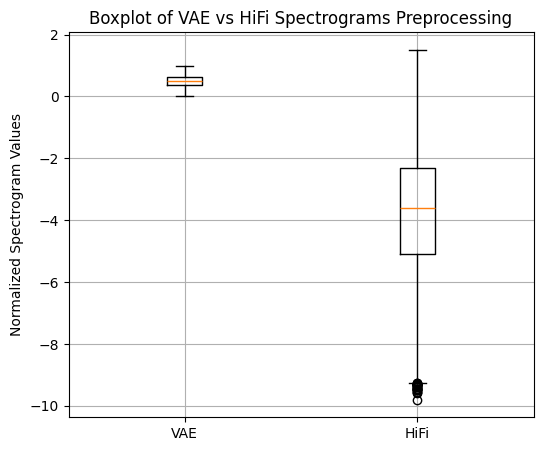

In [ ]:
import librosa
from librosa.util import normalize
from meldataset import get_test_filelist, spectral_normalize_torch
import json
import numpy as np
import matplotlib.pyplot as plt

with open('config_v1.json') as f:
    data = f.read()
json_config = json.loads(data)
h = AttrDict(json_config)
test_filelist = get_test_filelist('data', 'test_refs.txt')

audio_vae_norm = audio_preprocess_vae_gan(test_filelist[2], 22050)
audio_hifi_norm = normalize(audio_raw) * 0.95

# Espectrogramas (HIFI mode con librosa)
spec_hifi_norm = librosa.feature.melspectrogram(y=audio_hifi_norm, sr=h.sampling_rate, n_fft=h.n_fft, hop_length=h.hop_size, win_length=h.win_size, window='hann', center=False, pad_mode='reflect', power=1.0, fmin=h.fmin, fmax=h.fmax, n_mels=h.num_mels)
h_n_spec_hifi_norm = spectral_normalize_torch(torch.FloatTensor(spec_hifi_norm))

# Espectrogramas (VAE GAN mode con librosa)
spec_vae_norm = librosa.feature.melspectrogram(y=audio_vae_norm, sr=h.sampling_rate, n_fft=h.n_fft, n_mels=h.num_mels,fmin=h.fmin,power=1.0)
v_n_spec_vae_norm = vae_normalize(amp_to_db(spec_vae_norm))

plt.figure(figsize=(6, 5))
plt.boxplot([v_n_spec_vae_norm.flatten(), h_n_spec_hifi_norm.flatten()], tick_labels=['VAE', 'HiFi'])
plt.title('Boxplot of VAE vs HiFi Spectrograms Preprocessing')
plt.ylabel('Normalized Spectrogram Values')
plt.grid(True)
plt.show()

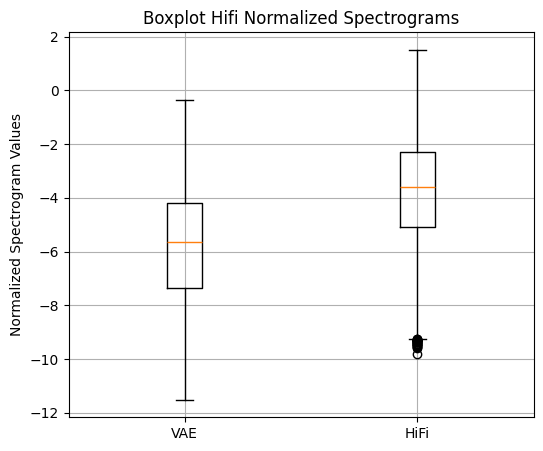

In [ ]:
import librosa
from librosa.util import normalize
from meldataset import get_test_filelist, spectral_normalize_torch
import json
import numpy as np
import matplotlib.pyplot as plt

with open('config_v1.json') as f:
    data = f.read()
json_config = json.loads(data)
h = AttrDict(json_config)
test_filelist = get_test_filelist('data', 'test_refs.txt')

audio_vae_norm = audio_preprocess_vae_gan(test_filelist[2], 22050)
audio_hifi_norm = normalize(audio_raw) * 0.95

spec_vae_norm = librosa.feature.melspectrogram(y=audio_vae_norm, sr=h.sampling_rate, n_fft=h.n_fft, n_mels=h.num_mels,fmin=h.fmin,power=1.0)
spec_hifi_norm = librosa.feature.melspectrogram(y=audio_hifi_norm, sr=h.sampling_rate, n_fft=h.n_fft, hop_length=h.hop_size, win_length=h.win_size, window='hann', center=False, pad_mode='reflect', power=1.0, fmin=h.fmin, fmax=h.fmax, n_mels=h.num_mels)

h_n_spec_vae_norm = spectral_normalize_torch(torch.FloatTensor(spec_vae_norm))
h_n_spec_hifi_norm = spectral_normalize_torch(torch.FloatTensor(spec_hifi_norm))

plt.figure(figsize=(6, 5))
plt.boxplot([h_n_spec_vae_norm.flatten(), h_n_spec_hifi_norm.flatten()], tick_labels=['VAE', 'HiFi'])
plt.title('Boxplot Hifi Normalized Spectrograms')
plt.ylabel('Normalized Spectrogram Values')
plt.grid(True)
plt.show()


## Crear archivos training_files.txt

In [ ]:
import os
# Crear archivo filelist/violin_train.txt
with open('violin_fragments_train.txt', 'w') as f:
    for wav in os.listdir('data/train/violin_fragments'):
        if wav.endswith('.wav'):
            path = '/'.join(['train/violin_fragments', wav])
            f.write(f'{path.replace(".wav","")}|{path.replace(".wav", ".npy")}\n')

# Crear archivo filelist/violin_test.txt
with open('violin_fragments_test.txt', 'w') as f:
    for wav in os.listdir('data/test/violin_fragments'):
        if wav.endswith('.wav'):
            path = '/'.join(['test/violin_fragments', wav])
            f.write(f'{path.replace(".wav","")}|{path.replace(".wav", ".npy")}\n')

In [ ]:
import os
import pickle

DATASET_ROOT_VOICES = r'datasets\dataset_1\v1'

train_refs_voices = pickle.load(open(os.path.join(DATASET_ROOT_VOICES, 'refs_train.pickle'), 'rb'))[0]
test_refs_voices = pickle.load(open(os.path.join(DATASET_ROOT_VOICES, 'refs_test.pickle'), 'rb'))[0]
eval_refs_voices = pickle.load(open(os.path.join(DATASET_ROOT_VOICES, 'refs_eval.pickle'), 'rb'))[0]

train_refs_voices = ['sing_voices_all/' + ref.replace(".wav", "") for ref in train_refs_voices]
test_refs_voices = ['sing_voices_all/' + ref.replace(".wav", "") for ref in test_refs_voices]
eval_refs_voices = ['sing_voices_all/' + ref.replace(".wav", "") for ref in eval_refs_voices]

DATASET_ROOT_READ_VOICES = r'datasets\dataset_7\v1'

train_refs_voices_read = pickle.load(open(os.path.join(DATASET_ROOT_READ_VOICES, 'refs_train.pickle'), 'rb'))
test_refs_voices_read = pickle.load(open(os.path.join(DATASET_ROOT_READ_VOICES, 'refs_test.pickle'), 'rb'))
eval_refs_voices_read = pickle.load(open(os.path.join(DATASET_ROOT_READ_VOICES, 'refs_eval.pickle'), 'rb'))

train_refs_vr = []
test_refs_vr = []
eval_refs_vr = []
for spkr in train_refs_voices_read:
    train_refs_vr += ['read_voices_8/' + ref.replace(".flac", "") for ref in train_refs_voices_read[spkr]]
    test_refs_vr += ['read_voices_8/' + ref.replace(".flac", "") for ref in test_refs_voices_read[spkr]]
    eval_refs_vr += ['read_voices_8/' + ref.replace(".flac", "") for ref in eval_refs_voices_read[spkr]]


with open('violin_fragments_train.txt', 'r') as f:
    train_refs_violin = [line.strip().split('|')[0] for line in f.readlines()]

with open('violin_fragments_test.txt', 'r') as f:
    test_refs_violin = [line.strip().split('|')[0] for line in f.readlines()]

train_refs = train_refs_voices + train_refs_vr + train_refs_violin
test_refs = test_refs_voices + test_refs_vr + test_refs_violin
eval_refs = eval_refs_voices + eval_refs_vr + test_refs_violin

with open('train_refs.txt', 'w') as f:
    for ref in train_refs:
        f.write(f'{ref}|{ref+".npy"}\n')

with open('test_refs.txt', 'w') as f:
    for ref in test_refs:
        f.write(f'{ref}|{ref+".npy"}\n')

with open('eval_refs.txt', 'w') as f:
    for ref in eval_refs:
        f.write(f'{ref}|{ref+".npy"}\n')

In [ ]:
import random

input_file = "eval_refs.txt"
output_file = "eval_refs_subset.txt"
n_per_group = 100

# Leer todas las líneas
with open(input_file, "r", encoding="utf-8") as f:
    lines = [line for line in f if line.strip()]

# Clasificar por grupo
groups = {"sing_voices_all": [], "read_voices_8": [], "test/violin_fragments": []}
for line in lines:
    if line.startswith("sing_voices_all"):
        groups["sing_voices_all"].append(line)
    elif line.startswith("read_voices_8"):
        groups["read_voices_8"].append(line)
    elif line.startswith("test/violin_fragments"):
        groups["test/violin_fragments"].append(line)

# Seleccionar hasta n_per_group de cada grupo
selected = []
for k in groups:
    n = min(n_per_group, len(groups[k]))
    selected += random.sample(groups[k], n)

# Mezclar el resultado final
random.shuffle(selected)

# Guardar el subset
with open(output_file, "w", encoding="utf-8") as f:
    f.writelines(selected)

print(f"Seleccionados {len(selected)} archivos (mismo número por grupo) en {output_file}")

Seleccionados 293 archivos (mismo número por grupo) en eval_refs_subset.txt


## Reescribir con otro sampling rate

In [ ]:
import librosa
import soundfile as sf
import os

input_dir = "data/read_voices_8"
for filename in os.listdir(input_dir):
    if filename.endswith(".flac"):
        filepath = os.path.join(input_dir, filename)
        y, sr = librosa.load(filepath, sr=22050)
        sf.write(filepath.replace('.flac', '.wav'), y, 22050)
        print(f"Processed {filename}")

input_dir = "data/sing_voices_all"
for filename in os.listdir(input_dir):
    if filename.endswith(".wav"):
        filepath = os.path.join(input_dir, filename)
        y, sr = librosa.load(filepath, sr=22050)
        sf.write(filepath, y, 22050)
        print(f"Processed {filename}")

Processed 196-122150-0000.flac
Processed 196-122150-0001.flac
Processed 196-122150-0002.flac
Processed 196-122150-0003.flac
Processed 196-122150-0004.flac
Processed 196-122150-0005.flac
Processed 196-122150-0006.flac
Processed 196-122150-0007.flac
Processed 196-122150-0008.flac
Processed 196-122150-0009.flac
Processed 196-122150-0010.flac
Processed 196-122150-0011.flac
Processed 196-122150-0012.flac
Processed 196-122150-0013.flac
Processed 196-122150-0014.flac
Processed 196-122150-0015.flac
Processed 196-122150-0016.flac
Processed 196-122150-0017.flac
Processed 196-122150-0018.flac
Processed 196-122150-0019.flac
Processed 196-122150-0020.flac
Processed 196-122150-0021.flac
Processed 196-122150-0022.flac
Processed 196-122150-0023.flac
Processed 196-122150-0024.flac
Processed 196-122150-0025.flac
Processed 196-122150-0026.flac
Processed 196-122150-0027.flac
Processed 196-122150-0028.flac
Processed 196-122150-0029.flac
Processed 196-122150-0030.flac
Processed 196-122150-0031.flac
Processe

## Fragmentar audios

In [ ]:
# Generar otro directorio con los audios fragmentados
import os
import shutil

SAMPLE_RATE = 22050

def segment_audio(audio_path, segment_length=5):
    y, sr = librosa.load(audio_path, sr=SAMPLE_RATE)
    segment_samples = int(segment_length * sr)  # Convertir a número de muestras
    segments = []
    for i in range(0, len(y), segment_samples):
        segment = y[i:i + segment_samples]
        if len(segment) == segment_samples:
            segments.append(segment)
    segments.append(y[-segment_samples:])  # Añadir el último segmento
    return segments

os.makedirs('data/train/violin_fragments', exist_ok=True)
os.makedirs('data/test/violin_fragments', exist_ok=True)
# Mover archivos a los directorios correspondientes
for wav in os.listdir('data/train/violin'):
    if wav.endswith('.wav'):
        path = os.path.join('data/train/violin', wav)
        segments = segment_audio(path, segment_length=5)
        for i, segment in enumerate(segments):
            segment_path = os.path.join('data/train/violin_fragments', f'{os.path.basename(path).replace(".wav", "")}_seg{i}.wav')
            sf.write(segment_path, segment, SAMPLE_RATE)
            print(f'Saved {segment_path}')

for wav in os.listdir('data/test/violin'):
    if wav.endswith('.wav'):
        path = os.path.join('data/test/violin', wav)
        segments = segment_audio(path, segment_length=5)
        for i, segment in enumerate(segments):
            segment_path = os.path.join('data/test/violin_fragments', f'{os.path.basename(path).replace(".wav", "")}_seg{i}.wav')
            sf.write(segment_path, segment, SAMPLE_RATE)
            print(f'Saved {segment_path}')

Saved data/test/violin_fragments\AuSep_1_vn_38_Jerusalem_seg0.wav
Saved data/test/violin_fragments\AuSep_1_vn_38_Jerusalem_seg1.wav
Saved data/test/violin_fragments\AuSep_1_vn_38_Jerusalem_seg2.wav
Saved data/test/violin_fragments\AuSep_1_vn_38_Jerusalem_seg3.wav
Saved data/test/violin_fragments\AuSep_1_vn_38_Jerusalem_seg4.wav
Saved data/test/violin_fragments\AuSep_1_vn_38_Jerusalem_seg5.wav
Saved data/test/violin_fragments\AuSep_1_vn_38_Jerusalem_seg6.wav
Saved data/test/violin_fragments\AuSep_1_vn_38_Jerusalem_seg7.wav
Saved data/test/violin_fragments\AuSep_1_vn_38_Jerusalem_seg8.wav
Saved data/test/violin_fragments\AuSep_1_vn_38_Jerusalem_seg9.wav
Saved data/test/violin_fragments\AuSep_1_vn_38_Jerusalem_seg10.wav
Saved data/test/violin_fragments\AuSep_1_vn_38_Jerusalem_seg11.wav
Saved data/test/violin_fragments\AuSep_1_vn_38_Jerusalem_seg12.wav
Saved data/test/violin_fragments\AuSep_1_vn_38_Jerusalem_seg13.wav
Saved data/test/violin_fragments\AuSep_1_vn_38_Jerusalem_seg14.wav
Saved

In [ ]:
# Ejemplo de uso
audio_path = r'data\train\violin\AuSep_1_vn_01_Jupiter.wav'
segments = segment_audio(audio_path, segment_length=10)  # Segmentos de 10 segundos
for i, segment in enumerate(segments):
    segment_path = f'data/train/violin_fragments/AuSep_1_vn_01_Jupiter_segment_{i}.wav'
    sf.write(segment_path, segment, SAMPLE_RATE)
    print(f'Saved {segment_path}')

Saved data/train/violin_fragments/AuSep_1_vn_01_Jupiter_segment_0.wav
Saved data/train/violin_fragments/AuSep_1_vn_01_Jupiter_segment_1.wav
Saved data/train/violin_fragments/AuSep_1_vn_01_Jupiter_segment_2.wav
Saved data/train/violin_fragments/AuSep_1_vn_01_Jupiter_segment_3.wav
Saved data/train/violin_fragments/AuSep_1_vn_01_Jupiter_segment_4.wav
Saved data/train/violin_fragments/AuSep_1_vn_01_Jupiter_segment_5.wav
Saved data/train/violin_fragments/AuSep_1_vn_01_Jupiter_segment_6.wav


# Entrenamiento

In [33]:
from train import *
from torch.amp import autocast, GradScaler
warnings.simplefilter(action='ignore', category=FutureWarning)
torch.backends.cudnn.benchmark = True
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    plt.figure(figsize=(12, 6))
    # plt.plot(history['Epochs'], history['G Loss'], label='G Loss')
    plt.plot(history['Epochs'], history['Mel Loss'], label='Mel Loss')
    plt.plot(history['Epochs'], history['Val Mel Loss'], label='Val Mel Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training History')
    plt.legend()
    plt.grid()
    plt.show()


def train_accelerate(rank, a, h):
    build_env(a.config, 'config.json', a.checkpoint_path)

    torch.manual_seed(h.seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(h.seed)
        h.num_gpus = torch.cuda.device_count()
        h.batch_size = int(h.batch_size / h.num_gpus)
        print('Batch size per GPU :', h.batch_size)
    else:
        pass
    
    if h.num_gpus > 1:
        init_process_group(backend=h.dist_config['dist_backend'], init_method=h.dist_config['dist_url'],
                           world_size=h.dist_config['world_size'] * h.num_gpus, rank=rank)

    device = torch.device('cuda:{:d}'.format(rank))
    print('Using device: ', device)
    
    generator = Generator(h).to(device)
    mpd = MultiPeriodDiscriminator().to(device)
    msd = MultiScaleDiscriminator().to(device)

    if rank == 0:
        # print(generator)
        os.makedirs(a.checkpoint_path, exist_ok=True)
        print("checkpoints directory : ", a.checkpoint_path)
    
    with open(a.checkpoint_path + '/a.json', 'w') as f:
        json.dump(a, f, indent=4)


    if os.path.isdir(a.checkpoint_path):
        cp_g = scan_checkpoint(a.checkpoint_path, 'g_')
        cp_do = scan_checkpoint(a.checkpoint_path, 'do_')


    steps = 0
    if cp_g is None or cp_do is None:
        state_dict_do = None
        last_epoch = -1
    else:
        state_dict_g = load_checkpoint(cp_g, device)
        state_dict_do = load_checkpoint(cp_do, device)
        generator.load_state_dict(state_dict_g['generator'])
        mpd.load_state_dict(state_dict_do['mpd'])
        msd.load_state_dict(state_dict_do['msd'])
        steps = state_dict_do['steps'] + 1
        last_epoch = state_dict_do['epoch']

    if os.path.exists(os.path.join(a.checkpoint_path, 'history.json')):
        with open(os.path.join(a.checkpoint_path, 'history.json'), 'r') as f:
            history = json.load(f)
        
        if history['Epochs'][-1] >= last_epoch:
            end = -(history['Epochs'][-1] - last_epoch + 1)
            history['Epochs'] = history['Epochs'][:end]
            history['G Loss'] = history['G Loss'][:end]
            history['Mel Loss'] = history['Mel Loss'][:end]
            history['Val Mel Loss'] = history['Val Mel Loss'][:end]
            
    else:
        history = {'G Loss': [], 'Mel Loss': [], 'Val Mel Loss': [], 'Epochs': []}


    if h.num_gpus > 1:
        generator = DistributedDataParallel(generator, device_ids=[rank]).to(device)
        mpd = DistributedDataParallel(mpd, device_ids=[rank]).to(device)
        msd = DistributedDataParallel(msd, device_ids=[rank]).to(device)

    optim_g = torch.optim.AdamW(generator.parameters(), h.learning_rate, betas=[h.adam_b1, h.adam_b2])
    optim_d = torch.optim.AdamW(itertools.chain(msd.parameters(), mpd.parameters()),
                                h.learning_rate, betas=[h.adam_b1, h.adam_b2])

    if state_dict_do is not None:
        optim_g.load_state_dict(state_dict_do['optim_g'])
        optim_d.load_state_dict(state_dict_do['optim_d'])

    scheduler_g = torch.optim.lr_scheduler.ExponentialLR(optim_g, gamma=h.lr_decay, last_epoch=last_epoch)
    scheduler_d = torch.optim.lr_scheduler.ExponentialLR(optim_d, gamma=h.lr_decay, last_epoch=last_epoch)

    training_filelist, validation_filelist = get_dataset_filelist(a)

    trainset = MelDataset(training_filelist, h.segment_size, h.n_fft, h.num_mels,
                          h.hop_size, h.win_size, h.sampling_rate, h.fmin, h.fmax, n_cache_reuse=0,
                          shuffle=False if h.num_gpus > 1 else True, fmax_loss=h.fmax_for_loss, device=device,
                          fine_tuning=a.fine_tuning, base_mels_path=a.input_mels_dir)

    train_sampler = DistributedSampler(trainset) if h.num_gpus > 1 else None

    train_loader = DataLoader(trainset, num_workers=h.num_workers, shuffle=True if h.num_gpus == 1 else False,
                              sampler=train_sampler,
                              batch_size=h.batch_size,
                              pin_memory=True,
                              drop_last=True)

    if rank == 0:
        validset = MelDataset(validation_filelist, h.segment_size, h.n_fft, h.num_mels,
                              h.hop_size, h.win_size, h.sampling_rate, h.fmin, h.fmax, False, False, n_cache_reuse=0,
                              fmax_loss=h.fmax_for_loss, device=device, fine_tuning=a.fine_tuning,
                              base_mels_path=a.input_mels_dir)
        validation_loader = DataLoader(validset, num_workers=1, shuffle=False,
                                       sampler=None,
                                       batch_size=1,
                                       pin_memory=True,
                                       drop_last=True)

        sw = SummaryWriter(os.path.join(a.checkpoint_path, 'logs'))

    generator.train()
    mpd.train()
    msd.train()
    scaler = GradScaler()

    for epoch in range(max(0, last_epoch), a.training_epochs):
        loss_gen_all_total = 0
        loss_mel_total = 0

        if rank == 0:
            start = time.time()
            print("Epoch: {}".format(epoch+1))

        if h.num_gpus > 1:
            train_sampler.set_epoch(epoch)

        for i, batch in enumerate(train_loader):
            if rank == 0:
                start_b = time.time()
            print(f'Batch {i} / {len(train_loader)} charged', end='\r')
            x, y, _, y_mel = batch
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            y_mel = y_mel.to(device, non_blocking=True)
            y = y.unsqueeze(1)

            # --------- DISCRIMINADOR ---------
            optim_d.zero_grad()

            with autocast('cuda'):
                y_g_hat = generator(x)
                y_g_hat_mel = mel_spectrogram(
                    y_g_hat.squeeze(1), h.n_fft, h.num_mels, h.sampling_rate,
                    h.hop_size, h.win_size, h.fmin, h.fmax_for_loss
                )

                # MPD
                y_df_hat_r, y_df_hat_g, _, _ = mpd(y, y_g_hat.detach())
                loss_disc_f, _, _ = discriminator_loss(y_df_hat_r, y_df_hat_g)

                # MSD
                y_ds_hat_r, y_ds_hat_g, _, _ = msd(y, y_g_hat.detach())
                loss_disc_s, _, _ = discriminator_loss(y_ds_hat_r, y_ds_hat_g)


                loss_disc_all = loss_disc_s + loss_disc_f

            scaler.scale(loss_disc_all).backward()
            scaler.step(optim_d)
            # print('Loss D actualizado', end='\r')

            # --------- GENERADOR ---------
            optim_g.zero_grad()

            with autocast('cuda'):
                # L1 Mel-Spectrogram Loss
                loss_mel = F.l1_loss(y_mel, y_g_hat_mel) 

                y_df_hat_r, y_df_hat_g, fmap_f_r, fmap_f_g = mpd(y, y_g_hat)
                y_ds_hat_r, y_ds_hat_g, fmap_s_r, fmap_s_g = msd(y, y_g_hat)

                loss_fm_f = feature_loss(fmap_f_r, fmap_f_g)
                loss_fm_s = feature_loss(fmap_s_r, fmap_s_g)
                loss_gen_f, _ = generator_loss(y_df_hat_g)
                loss_gen_s, _ = generator_loss(y_ds_hat_g)

                loss_gen_all = loss_gen_s + loss_gen_f + loss_fm_s + loss_fm_f + (loss_mel * 45)

            scaler.scale(loss_gen_all).backward()
            scaler.step(optim_g)
            # print('Loss G actualizado', end='\r')
            
            # Actualiza el GradScaler
            scaler.update()
            # print('GradScaler actualizado', end='\r')
            loss_gen_all_total += loss_gen_all.item()
            loss_mel_total += loss_mel.item()

            if rank == 0:
                # STDOUT logging
                if steps % a.stdout_interval == 0:
                    with torch.no_grad():
                        mel_error = F.l1_loss(y_mel, y_g_hat_mel).item()

                    print('Steps : {:d}, Gen Loss Total : {:4.3f}, Mel-Spec. Error : {:4.3f}, s/b : {:4.3f}'.
                          format(steps, loss_gen_all, mel_error, time.time() - start_b))

                # checkpointing
                if steps % a.checkpoint_interval == 0 and steps != 0:
                    checkpoint_path = "{}/g_{:08d}".format(a.checkpoint_path, steps)
                    save_checkpoint(checkpoint_path,
                                    {'generator': (generator.module if h.num_gpus > 1 else generator).state_dict()})
                    checkpoint_path = "{}/do_{:08d}".format(a.checkpoint_path, steps)
                    save_checkpoint(checkpoint_path, 
                                    {'mpd': (mpd.module if h.num_gpus > 1
                                                         else mpd).state_dict(),
                                     'msd': (msd.module if h.num_gpus > 1
                                                         else msd).state_dict(),
                                     'optim_g': optim_g.state_dict(), 'optim_d': optim_d.state_dict(), 'steps': steps,
                                     'epoch': epoch})

                # Tensorboard summary logging
                if steps % a.summary_interval == 0:
                    sw.add_scalar("training/gen_loss_total", loss_gen_all, steps)
                    sw.add_scalar("training/mel_spec_error", mel_error, steps)

            steps += 1

        # Validation
        generator.eval()
        torch.cuda.empty_cache()
        val_err_tot = 0
        # print('Validating...')
        with torch.no_grad():
            for j, batch in enumerate(validation_loader):
                print(f'Validation batch {j} / {len(validation_loader)} charged', end='\r')
                x, y, _, y_mel = batch
                y_g_hat = generator(x.to(device))
                y_mel = torch.autograd.Variable(y_mel.to(device, non_blocking=True))
                y_g_hat_mel = mel_spectrogram(y_g_hat.squeeze(1), h.n_fft, h.num_mels, h.sampling_rate,
                                                h.hop_size, h.win_size,
                                                h.fmin, h.fmax_for_loss)

                min_time = min(y_mel.shape[2], y_g_hat_mel.shape[2])
                y_mel = y_mel[:, :, :min_time]
                y_g_hat_mel = y_g_hat_mel[:, :, :min_time]

                val_err_tot += F.l1_loss(y_mel, y_g_hat_mel).item()

                if j <= 4:
                    if steps == 0:
                        sw.add_audio('gt/y_{}'.format(j), y[0], steps, h.sampling_rate)
                        sw.add_figure('gt/y_spec_{}'.format(j), plot_spectrogram(x[0]), steps)

                    sw.add_audio('generated/y_hat_{}'.format(j), y_g_hat[0], steps, h.sampling_rate)
                    y_hat_spec = mel_spectrogram(y_g_hat.squeeze(1), h.n_fft, h.num_mels,
                                                    h.sampling_rate, h.hop_size, h.win_size,
                                                    h.fmin, h.fmax)
                    sw.add_figure('generated/y_hat_spec_{}'.format(j),
                                    plot_spectrogram(y_hat_spec.squeeze(0).cpu().numpy()), steps)

            val_err = val_err_tot / (j+1)
            sw.add_scalar("validation/mel_spec_error", val_err, steps)

        generator.train()

        scheduler_g.step()
        scheduler_d.step()
        
        if rank == 0:
            print('Time taken for epoch {} is {} sec'.format(epoch + 1, int(time.time() - start)))
            print('Avg Gen Loss: {:4.3f}, Mel-Spec Error: {:4.3f}, Val Mel-Spec Error: {:4.3f}'.format(
                loss_gen_all_total / len(train_loader), loss_mel_total / len(train_loader), val_err))
            history['G Loss'].append(loss_gen_all_total / len(train_loader))
            history['Mel Loss'].append(loss_mel_total / len(train_loader))
            history['Val Mel Loss'].append(val_err)
            history['Epochs'].append(epoch)

            with open(os.path.join(a.checkpoint_path, 'history.json'), 'w') as f:
                json.dump(history, f, indent=4)

In [2]:
a = {
    'group_name': None,
    'input_wavs_dir': 'data',
    'input_mels_dir': 'data',
    'input_training_file': 'violin_fragments_train.txt',
    'input_validation_file': 'violin_fragments_test.txt',
    'checkpoint_path': 'cp_hifigan',
    'config': 'config_v1.json',
    'training_epochs': 3100,
    'stdout_interval': 5,
    'checkpoint_interval': 500,
    'summary_interval': 100,
    'validation_interval': 1000,
    'fine_tuning': False
}

a = AttrDict(a)

with open(a.config) as f:
    data = f.read()

json_config = json.loads(data)
h = AttrDict(json_config)

# Experimentos

In [2]:
a = {
    'group_name': None,
    'input_wavs_dir': 'data',
    'input_mels_dir': 'data',
    'input_training_file': 'violin_fragments_train.txt',
    'input_validation_file': 'violin_fragments_test.txt',
    'checkpoint_path': 'experiments/hifi_1_pretrained',
    'config': 'config_v1.json',
    'training_epochs': 3100,
    'stdout_interval': 10,
    'checkpoint_interval': 1000,
    'summary_interval': 100,
    'validation_interval': 1000,
    'fine_tuning': False
}

a = AttrDict(a)

with open(a.config) as f:
    data = f.read()

json_config = json.loads(data)
h = AttrDict(json_config)

train_accelerate(0, a, h)

Batch size per GPU : 16
Using device:  cuda:0
checkpoints directory :  experiments/hifi_1_pretrained
Loading 'experiments/hifi_1_pretrained\g_02524000'
Complete.
Loading 'experiments/hifi_1_pretrained\do_02524000'
Complete.
Epoch: 756
Steps : 2524010, Gen Loss Total : 41.983, Mel-Spec. Error : 0.316, s/b : 1.245
Steps : 2524020, Gen Loss Total : 38.214, Mel-Spec. Error : 0.282, s/b : 1.246
Steps : 2524030, Gen Loss Total : 41.652, Mel-Spec. Error : 0.310, s/b : 1.217
Time taken for epoch 756 is 85 sec
Avg Gen Loss: 39.228, Mel-Spec Error: 0.299, Val Mel-Spec Error: 0.305
Epoch: 757
Steps : 2524040, Gen Loss Total : 40.648, Mel-Spec. Error : 0.306, s/b : 1.248
Steps : 2524050, Gen Loss Total : 40.068, Mel-Spec. Error : 0.301, s/b : 1.231
Steps : 2524060, Gen Loss Total : 38.043, Mel-Spec. Error : 0.296, s/b : 1.237
Steps : 2524070, Gen Loss Total : 39.782, Mel-Spec. Error : 0.299, s/b : 1.274
Time taken for epoch 757 is 70 sec
Avg Gen Loss: 39.491, Mel-Spec Error: 0.300, Val Mel-Spec Er

KeyboardInterrupt: 

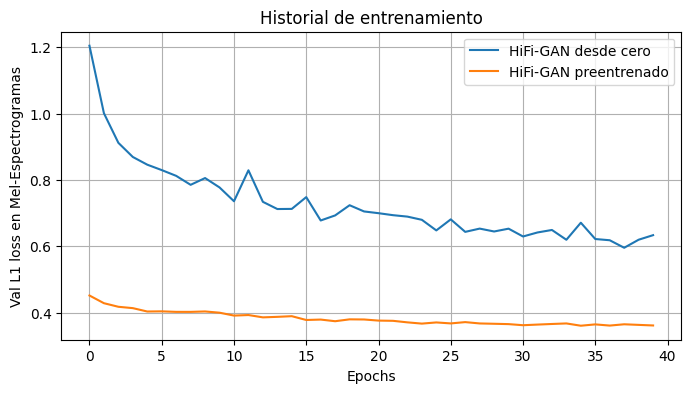

In [ ]:
with open('experiments\hifi_1\history.json', 'r') as f:
    history = json.load(f)

with open('experiments\hifi_1_pretrained\history.json', 'r') as f:
    history2 = json.load(f)

plt.figure(figsize=(8, 4))
plt.plot(history['Epochs'][:40], history['Val Mel Loss'][:40], label='HiFi-GAN desde cero')
plt.plot(range(40), history2['Val Mel Loss'][:40], label='HiFi-GAN preentrenado')
plt.xlabel('Epochs')
plt.ylabel('Val L1 loss en Mel-Espectrogramas')
plt.title('Historial de entrenamiento')
plt.legend()
plt.grid()
plt.show()

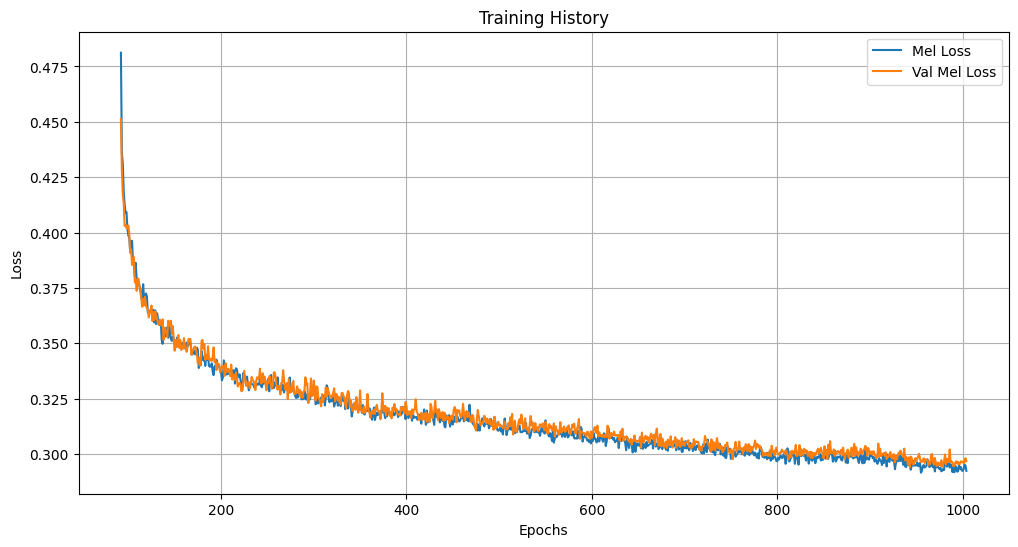

In [ ]:
# Ver el historial de entrenamiento
if os.path.exists(os.path.join(a.checkpoint_path, 'history.json')):
    with open(os.path.join(a.checkpoint_path, 'history.json'), 'r') as f:
        history = json.load(f)

# Graficar el historial de entrenamiento
plot_history(history)

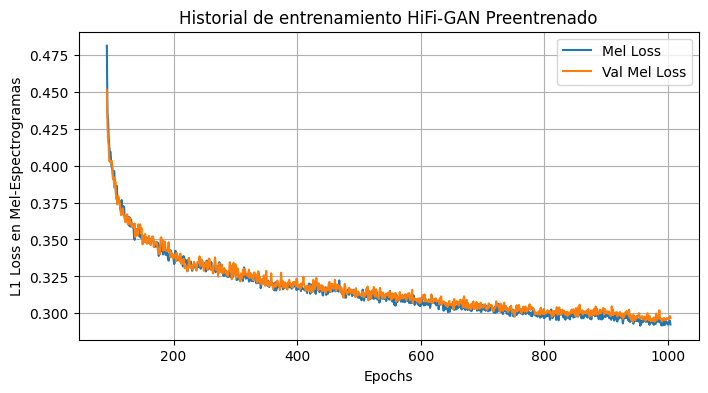

In [53]:
plt.figure(figsize=(8, 4))
plt.plot(history2['Epochs'], history2['Mel Loss'], label='Mel Loss')
plt.plot(history2['Epochs'], history2['Val Mel Loss'], label='Val Mel Loss')
plt.xlabel('Epochs')
plt.ylabel('L1 Loss en Mel-Espectrogramas')
plt.title('Historial de entrenamiento HiFi-GAN Preentrenado')
plt.legend()
plt.grid()
plt.show()

In [ ]:
def fix_error(history):
    for i in range(len(history['Epochs'])-1):
        if history['Epochs'][i] + 1 != history['Epochs'][i+1]:
            print(f'{i}: Error en el epoch', history['Epochs'][i], 'vs', history['Epochs'][i+1])
            print(history['Epochs'][i-5:i+5])
            desfase = abs(history['Epochs'][i+1] - history['Epochs'][i])
            print(f'Desfase: {desfase} epochs')
            to_remove = history['Epochs'][i-desfase:i+1]
            print(f'Eliminando epochs: {to_remove}')
            history['Epochs'] = history['Epochs'][:i-desfase] + history['Epochs'][i+1:]
            history['G Loss'] = history['G Loss'][:i-desfase] + history['G Loss'][i+1:]
            history['Mel Loss'] = history['Mel Loss'][:i-desfase] + history['Mel Loss'][i+1:]
            history['Val Mel Loss'] = history['Val Mel Loss'][:i-desfase] + history['Val Mel Loss'][i+1:]
            print(history['Epochs'][i-desfase-5:i-desfase+5])
            break
    
    return history

history = fix_error(history)
with open(os.path.join(a.checkpoint_path, 'history.json'), 'w') as f:
    json.dump(history, f, indent=4)

In [3]:
a = {
    'group_name': None,
    'input_wavs_dir': 'data',
    'input_mels_dir': 'data',
    'input_training_file': 'train_refs.txt',
    'input_validation_file': 'eval_refs_subset.txt',
    'checkpoint_path': 'experiments/hifi_all_ft',
    'config': 'config_v1.json',
    'training_epochs': 3100,
    'stdout_interval': 10,
    'checkpoint_interval': 1000,
    'summary_interval': 100,
    'validation_interval': 1000,
    'fine_tuning': False
}

a = AttrDict(a)

with open(a.config) as f:
    data = f.read()

json_config = json.loads(data)
h = AttrDict(json_config)

train_accelerate(0, a, h)

Batch size per GPU : 16
Using device:  cuda:0
checkpoints directory :  experiments/hifi_all_ft
Loading 'experiments/hifi_all_ft\g_02533600'
Complete.
Loading 'experiments/hifi_all_ft\do_02533600'
Complete.
Epoch: 1005
Steps : 2533610, Gen Loss Total : 34.956, Mel-Spec. Error : 0.349, s/b : 1.308
Steps : 2533620, Gen Loss Total : 33.862, Mel-Spec. Error : 0.343, s/b : 1.325
Steps : 2533630, Gen Loss Total : 34.510, Mel-Spec. Error : 0.335, s/b : 1.336
Steps : 2533640, Gen Loss Total : 31.385, Mel-Spec. Error : 0.343, s/b : 1.324
Steps : 2533650, Gen Loss Total : 32.164, Mel-Spec. Error : 0.329, s/b : 1.348
Steps : 2533660, Gen Loss Total : 30.490, Mel-Spec. Error : 0.330, s/b : 1.302
Steps : 2533670, Gen Loss Total : 33.456, Mel-Spec. Error : 0.326, s/b : 1.321
Steps : 2533680, Gen Loss Total : 30.390, Mel-Spec. Error : 0.342, s/b : 1.316
Steps : 2533690, Gen Loss Total : 34.487, Mel-Spec. Error : 0.354, s/b : 1.300
Steps : 2533700, Gen Loss Total : 34.972, Mel-Spec. Error : 0.362, s/b 

KeyboardInterrupt: 

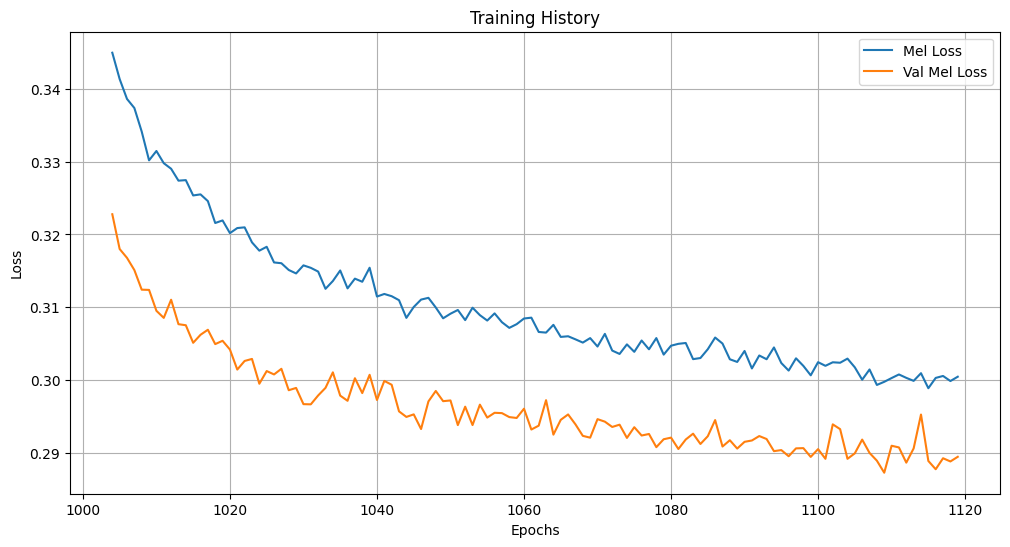

In [ ]:
# Ver el historial de entrenamiento
if os.path.exists(os.path.join(a.checkpoint_path, 'history.json')):
    with open(os.path.join(a.checkpoint_path, 'history.json'), 'r') as f:
        history = json.load(f)

# Graficar el historial de entrenamiento
plot_history(history)

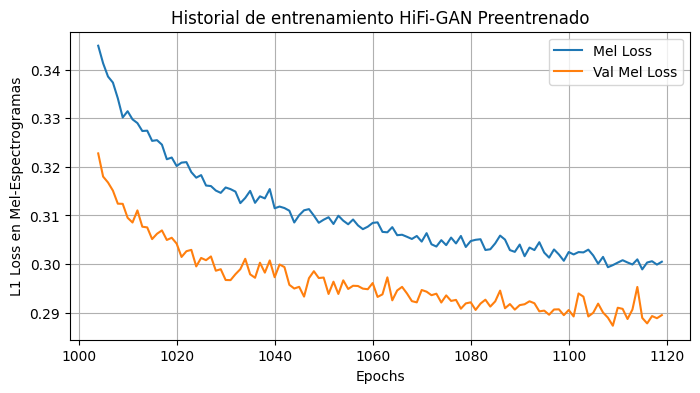

In [57]:
with open('experiments/hifi_all_ft/history.json', 'r') as f:
    history = json.load(f)

plt.figure(figsize=(8, 4))
plt.plot(history['Epochs'], history['Mel Loss'], label='Mel Loss')
plt.plot(history['Epochs'], history['Val Mel Loss'], label='Val Mel Loss')
plt.xlabel('Epochs')
plt.ylabel('L1 Loss en Mel-Espectrogramas')
plt.title('Historial de entrenamiento HiFi-GAN Preentrenado')
plt.legend()
plt.grid()
plt.show()

# Inferencias y evaluación

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import glob
import os
import numpy as np
import argparse
import json
import torch
from scipy.io.wavfile import write
from env import AttrDict
from meldataset import MAX_WAV_VALUE, get_test_filelist
from models import Generator
import IPython.display as ipd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def dynamic_range_compression_torch(x, C=1, clip_val=1e-5):
    return torch.log(torch.clamp(x, min=clip_val) * C)


def spectral_normalize_torch(magnitudes):
    output = dynamic_range_compression_torch(magnitudes)
    return output


def load_checkpoint(filepath, device):
    assert os.path.isfile(filepath)
    print("Loading '{}'".format(filepath))
    checkpoint_dict = torch.load(filepath, map_location=device)
    print("Complete.")
    return checkpoint_dict


def scan_checkpoint(cp_dir, prefix):
    pattern = os.path.join(cp_dir, prefix + '*')
    cp_list = glob.glob(pattern)
    if len(cp_list) == 0:
        return ''
    return sorted(cp_list)[-1]


def inference(a):
    generator = Generator(h).to(device)

    state_dict_g = load_checkpoint(a.checkpoint_file, device)
    generator.load_state_dict(state_dict_g['generator'])

    filelist = os.listdir(a.input_mels_dir)

    os.makedirs(a.output_dir, exist_ok=True)

    generator.eval()
    generator.remove_weight_norm()
    with torch.no_grad():
        for i, filname in enumerate(filelist):
            x = np.load(os.path.join(a.input_mels_dir, filname))
            x = torch.FloatTensor(x).to(device)
            y_g_hat = generator(x)
            audio = y_g_hat.squeeze()
            audio = audio * MAX_WAV_VALUE
            audio = audio.cpu().numpy().astype('int16')

            output_file = os.path.join(a.output_dir, os.path.splitext(filname)[0] + '_generated_e2e.wav')
            write(output_file, h.sampling_rate, audio)
            print(output_file)

## Inferencia desde un mel espectrograma

In [ ]:
file = 'mel copy 2.npy'
checkpoint_file = 'experiments\hifi_1_pretrained\g_02533000'
config_file = os.path.join(os.path.split(checkpoint_file)[0], 'config.json')
a_file = os.path.join(os.path.split(checkpoint_file)[0], 'a.json')

with open(config_file) as f:
    data = f.read()
json_config = json.loads(data)
h = AttrDict(json_config)

with open(a_file) as f:
    data = f.read()
a = json.loads(data)
a = AttrDict(a)

generator = Generator(h).to(device)

state_dict_g = load_checkpoint(checkpoint_file, device)
generator.load_state_dict(state_dict_g['generator'])

generator.eval()
generator.remove_weight_norm()
with torch.no_grad():
    x = np.load(file)
    x = torch.FloatTensor(x).to(device)
    normalized_mel = spectral_normalize_torch(x)
    y_g_hat = generator(normalized_mel)
    audio = y_g_hat.squeeze()
    audio = audio * MAX_WAV_VALUE
    audio = audio.cpu().numpy().astype('int16')
output_file = 'generated_e2e.wav'
write(output_file, h.sampling_rate, audio)

ipd.display(ipd.Audio(audio, rate=22050))

## Evaluación de un conjunto de datos

In [ ]:
import librosa

def calculate_mcd(reference_audio, generated_audio, n_mfcc=13, sampling_rate=22050):

    # Calcular las MFCCs para el audio de referencias
    mel_ref = librosa.feature.mfcc(y=reference_audio, sr=sampling_rate, n_mfcc=n_mfcc).T
    mel_ref = mel_ref[:, 1:]
    # Calcular las MFCCs para el audio generado
    mel_gen = librosa.feature.mfcc(y=generated_audio, sr=sampling_rate, n_mfcc=n_mfcc).T
    mel_gen = mel_gen[:, 1:]
    # Asegurarse de que las dimensiones de mel_ref y mel_gen sean iguales
    if mel_ref.shape != mel_gen.shape:
        min_length = min(mel_ref.shape[1], mel_gen.shape[1])
        mel_ref = mel_ref[:, :min_length]
        mel_gen = mel_gen[:, :min_length]

    dist = np.linalg.norm(mel_ref - mel_gen, axis=1)
    mcd = np.mean(np.sqrt(dist))  
    return mcd

In [ ]:
test_filelist = get_test_filelist('data', 'violin_fragments_test.txt')

testset = MelDataset(test_filelist, h.segment_size, h.n_fft, h.num_mels,
                        h.hop_size, h.win_size, h.sampling_rate, h.fmin, h.fmax, False, False, n_cache_reuse=0,
                        fmax_loss=h.fmax_for_loss, device=device, fine_tuning=a.fine_tuning,
                        base_mels_path=a.input_mels_dir)
validation_loader = DataLoader(testset, num_workers=1, shuffle=False,
                                sampler=None,
                                batch_size=1,
                                pin_memory=True,
                                drop_last=True)

# Validation
generator.eval()
torch.cuda.empty_cache()
val_err_tot = 0
mcd_tot = 0
with torch.no_grad():
    for j, batch in enumerate(validation_loader):
        print(j, end='\r')
        x, y, _, y_mel = batch
        y_g_hat = generator(x.to(device))
        y_mel = torch.autograd.Variable(y_mel.to(device, non_blocking=True))
        y_g_hat_mel = mel_spectrogram(y_g_hat.squeeze(1), h.n_fft, h.num_mels, h.sampling_rate,
                                        h.hop_size, h.win_size,
                                        h.fmin, h.fmax_for_loss)

        val_err_tot += F.l1_loss(y_mel, y_g_hat_mel).item()
        mcd_tot += calculate_mcd(y.squeeze().cpu().numpy(), y_g_hat.squeeze().cpu().numpy())
    val_err = val_err_tot / (j+1)
    mcd = mcd_tot / (j+1)
    

print('Test MCD: {:.4f}'.format(mcd))
print('Test Mel-Spectrogram Error: {:.4f}'.format(val_err))

with open(os.path.join(a.checkpoint_path, os.path.split(checkpoint_file)[-1] + '_validation_results_violin.json'), 'w') as f:
    json.dump({
        'test_mcd': mcd,
        'test_mel_spectrogram_error': val_err
    }, f, indent=4)

Test MCD: 4.0058
Test Mel-Spectrogram Error: 0.3100


In [59]:
with open('experiments\hifi_1_pretrained\g_02533000_validation_results_violin.json', 'r') as f:
    violin_results_1 = json.load(f)

with open('experiments\hifi_all_ft\g_02564000_validation_results_violin.json', 'r') as f:
    violin_results_2 = json.load(f)

with open('experiments\hifi_1_pretrained\g_02533000_validation_results_all.json', 'r') as f:
    all_results_1 = json.load(f)

with open('experiments\hifi_all_ft\g_02564000_validation_results_all.json', 'r') as f:
    all_results_2 = json.load(f)

print('Violin results violin model:', violin_results_1)
print('Violin results all model:', violin_results_2)
print('All results violin model:', all_results_1)
print('All results all model:', all_results_2)

Violin results violin model: {'test_mcd': 3.807365602321839, 'test_mel_spectrogram_error': 0.2969222398621313}
Violin results all model: {'test_mcd': 4.005765894825539, 'test_mel_spectrogram_error': 0.3100238187929218}
All results violin model: {'test_mcd': 4.7161776415006385, 'test_mel_spectrogram_error': 0.41337301653670516}
All results all model: {'test_mcd': 3.804851866143895, 'test_mel_spectrogram_error': 0.29596977510790184}


## Inferencia de espectrogramas generados con VAE-GAN

In [ ]:
import pickle
import os

DATASET_NAME = 'dataset_1'
VERSION = 'v2'
MODEL_NAME = 'd1_v2_model_3'
SRC_SPKR = '2'
TRGT_SPKR = '2'

# Ruta al directorio donde se encuentran los mel-espectrogramas generados
PATH = rf'results\{DATASET_NAME}\{VERSION}\{MODEL_NAME}\test_results\{SRC_SPKR}_{TRGT_SPKR}\converted_mels'

checkpoint_file = r'experiments\hifi_all_ft\g_02564000'
config_file = os.path.join(os.path.split(checkpoint_file)[0], 'config.json')

with open(config_file) as f:
    data = f.read()
json_config = json.loads(data)
h = AttrDict(json_config)

OUTPUT_DIR = PATH.replace('converted_mels', 'HIFI_converted_audios')
os.makedirs(OUTPUT_DIR, exist_ok=True)

with open(os.path.join(os.path.split(OUTPUT_DIR)[0], 'hifi_model.txt'), 'w') as f:
    f.write(checkpoint_file)

generator = Generator(h).to(device)

state_dict_g = load_checkpoint(checkpoint_file, device)
generator.load_state_dict(state_dict_g['generator'])

generator.eval()
generator.remove_weight_norm()

with torch.no_grad():
    for file in os.listdir(PATH):
        if not file.endswith('.npy'):
            continue
        mel_spectrogram = np.load(os.path.join(PATH, file))
        x = torch.FloatTensor(mel_spectrogram).to(device)
        normalized_mel = spectral_normalize_torch(x)
        y_g_hat = generator(normalized_mel)
        audio = y_g_hat.squeeze()
        audio = audio * MAX_WAV_VALUE
        audio = audio.cpu().numpy().astype('int16')

        # ipd.display(ipd.Audio(audio, rate=22050))
        output_file = os.path.join(OUTPUT_DIR, file.replace('.npy', '.wav'))
        print(f'Saving {output_file}')
        write(output_file, h.sampling_rate, audio)